# Lecture 5) Neural Networks are no Black Box Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sl

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn import linear_model

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor


%matplotlib inline
import scipy as sc
import math as ma
from scipy import linalg, optimize, constants, interpolate, special, stats
from math import exp, pow, sqrt, log

import seaborn as sns #spezielle Graphikdarstellungen
import statsmodels.api as sm
import statsmodels.stats.api as sms

#import theano 
import tensorflow as tf
from tensorflow import keras

from keras.callbacks import Callback
from keras.models import Sequential, Model
from keras.layers import InputLayer,Dense, Activation
from keras.optimizers import SGD #Stochastic Gradient Descent
from keras.utils import to_categorical  
from keras.utils import plot_model



In [2]:
# updatable plot

from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

### 5.1) Model setup

In the last theory lecture we discussed that Neural networks are no Black-Box models.  

We can e.g. look for activations on the hidden layer during training or analyze feature sensitivities to explain which Input Features were important for the target.

We use again the Housing Dataset and prepare it for a simple FFNN Regression Model.

In [3]:
# Import the data
Housing = pd.read_csv("../Data/housing.csv")
Housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


We found out that some of the columns had missing entries. We just remove the respective variables:

In [4]:
Housing_new=Housing.drop(columns=['total_bedrooms','ocean_proximity'])
Housing_new.head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,565.0,259.0,3.8462,342200.0


We analyzed a Correlation HeatMap to find out if there were interactions between the input features and which features had the strongest linear relationship with the target (median house value):

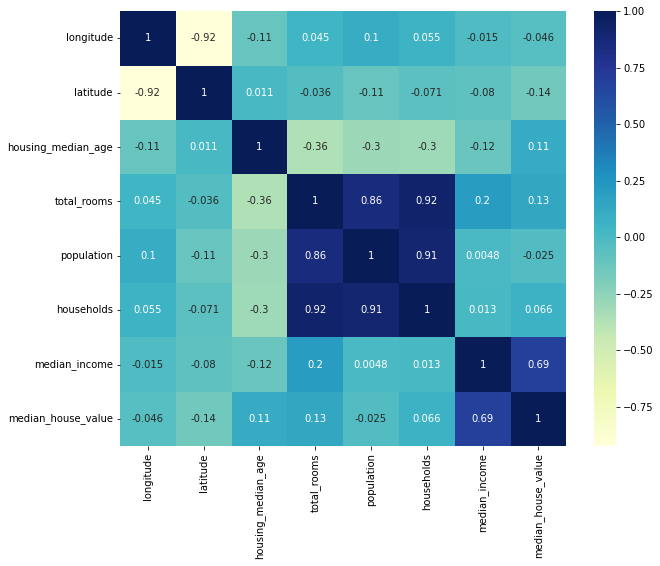

In [5]:
# Plot the correlation-Heatmap
fig = plt.figure(figsize=(10, 8));
sns.heatmap(Housing_new.corr(), cmap="YlGnBu", annot=True);
  
#plt.show()

The plot would suggest, that median_income, total_rooms and latitude are the most important features. But of course this is only based on the assumption of linear relationships...
Our Model may tell another story :-)

Now we prepare the input and the target data:

In [6]:
X_housing=Housing[['longitude','latitude','housing_median_age','total_rooms','population','households','median_income']]
y_housing=Housing['median_house_value']

X_housing.head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income
0,-122.23,37.88,41.0,880.0,322.0,126.0,8.3252
1,-122.22,37.86,21.0,7099.0,2401.0,1138.0,8.3014
2,-122.24,37.85,52.0,1467.0,496.0,177.0,7.2574
3,-122.25,37.85,52.0,1274.0,558.0,219.0,5.6431
4,-122.25,37.85,52.0,1627.0,565.0,259.0,3.8462


We split the data into train and test set and scale the input features and the target:

In [7]:
# Split the data into train and test sets
X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(X_housing, y_housing, test_size=0.3, random_state=42)

# Standardize the features
Xscaler = StandardScaler()
X_housing_train = Xscaler.fit_transform(X_housing_train)
X_housing_test = Xscaler.transform(X_housing_test)

In [8]:
# Standardize the target
Yscaler = StandardScaler()
y_housing_train_sc = Yscaler.fit_transform(np.array(y_housing_train).reshape(-1,1))
y_housing_test_sc = Yscaler.transform(np.array(y_housing_test).reshape(-1,1))

print(X_housing_train.shape)
print(X_housing_test.shape)

print(y_housing_train_sc.shape)
print(y_housing_test_sc.shape)

(14448, 7)
(6192, 7)
(14448, 1)
(6192, 1)


We now want to set up a first very simple Feedforward NN.

If we want to analyze how learning works, the model needs to have enough predictive power (i.e. the model performance has to be large enough).

Thus, the first task is to find a good configuration for our simple FFNN:

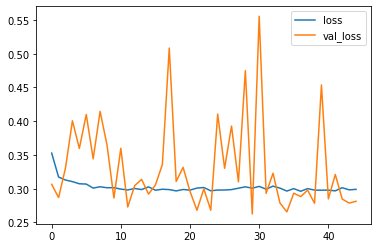

In [9]:
tf.random.set_seed(42)

EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)

NNRegModel=Sequential()

NNRegModel.add(InputLayer(input_shape=(7,))) # Input shape = 7 features
NNRegModel.add(Dense(5,activation='tanh',use_bias=True))
NNRegModel.add(Dense(1,use_bias=True))

#sgd
sgd = SGD(learning_rate=0.3)
#Adam
myAdam=keras.optimizers.Adam(learning_rate=0.03, beta_1=0.9, beta_2=0.999, amsgrad=True)

NNRegModel.compile(loss='mean_squared_error', optimizer=sgd)

NNRegModel.fit(X_housing_train, y_housing_train_sc,
          shuffle=True,
          epochs=50,
          batch_size=20,
          verbose=0,
          validation_data=(X_housing_test, y_housing_test_sc),                  
          callbacks=[plot_losses, EarlyStopping]);

In [10]:
y_pred_train_sc = NNRegModel.predict(X_housing_train)
y_pred_test_sc = NNRegModel.predict(X_housing_test)

194/194 [==============================] - 0s 1ms/step


In [11]:
# Inverse transform to get the predicted values back to the original scale
y_pred_train_original = Yscaler.inverse_transform(y_pred_train_sc)
y_pred_test_original = Yscaler.inverse_transform(y_pred_test_sc)

r2_train=r2_score(y_pred_train_original,np.array(y_housing_train))
r2_test=r2_score(y_pred_test_original,np.array(y_housing_test))

rmse_train=np.sqrt(mean_squared_error(y_pred_train_original,np.array(y_housing_train)))
rmse_test=np.sqrt(mean_squared_error(y_pred_test_original,np.array(y_housing_test)))

rmse_perc_train=rmse_train/np.mean(np.array(y_housing_train))
rmse_perc_test=rmse_test/np.mean(np.array(y_housing_test))

print(r2_train, r2_test)
print(rmse_train, rmse_test)
print(rmse_perc_train, rmse_perc_test)

0.641967638680554 0.6413791521776551
59469.48183992742 59310.82005220996
0.2873977551121893 0.28694598056491316


### Exercise 1)

- The Loss curve looks not great! It is very spiky and seems not to have converged yet. Experiment with a larger batch size and a smaller learning rate.
- We have 7 Input Features but only 5 Neurons -> Input signal is compressed. Is the performance better if you have more than 5 Neurons in the hidden layer?
- 50 Epochs might not be enough. Let the model train longer
- What is the overall best configuration?

### 5.2) Analyze the behaviour of activations in the Hidden Layer

### Why Analyze Activations in Neural Networks?

Analyzing the activations of a neural network is a powerful way to understand how it processes input data. Each neuron in a layer produces an activation, which represents how "active" the neuron is in response to specific input features. By examining these activations during training, we can:

- Detect Overfitting: If neurons exhibit similar patterns (high correlations), the model may be over-redundant or overfitting.  

- Identify Dead Neurons: If certain neurons never activate, they contribute nothing to the network's learning.  
- Optimize Architecture: Understanding activations helps refine layer sizes and activation functions.  


For our "Example Use Case" that means:

If you're training a neural network to predict housing prices, you might want to analyze the activations of neurons in the first hidden layer to ensure that each neuron is learning different aspects of the input features (e.g., number of rooms, population, median income). By monitoring correlations between activations, you can check whether too many neurons are becoming highly correlated, which may indicate unnecessary complexity in the network.

We define our own Callback to log the activations during training

### Breakdown of the ActivationLogger Class


This class extends tf.keras.callbacks.Callback, enabling us to monitor and log activations at the end of each training epoch. Here's a step-by-step explanation of its components:

#### 1. Initialization (__init__)

    def __init__(self, model, layer_name, data):
        self.model = model  # The trained model
        self.layer_name = layer_name  # The layer to monitor (e.g., 'dense_layer')
        self.data = data  # Input data to compute activations
        self.epoch_activations = []  # List to store activations per epoch
        
        
Purpose: Prepares the logger to monitor activations.  

self.model: Holds the neural network being trained.  

self.layer_name: Identifies the specific layer whose activations are analyzed.  

self.data: The input data (e.g., training data) used to calculate activations.  

self.epoch_activations: Stores activation values at the end of each epoch for later analysis.  


#### 2. On Epoch End (on_epoch_end)

    def on_epoch_end(self, epoch, logs=None):
        layer_output = tf.keras.Model(
            inputs=self.model.input,  # Original model input
            outputs=self.model.get_layer(self.layer_name).output  # Layer's output
    )
        activation_values = layer_output(self.data, training=False)  # Get activations
        self.epoch_activations.append(activation_values.numpy())  # Store as NumPy array

### Here is Step-by-Step whats going on:

- Model Extraction:

    layer_output = tf.keras.Model(
        inputs=self.model.input,
        outputs=self.model.get_layer(self.layer_name).output
    )
    
Creates a new temporary model (layer_output) that maps the original inputs to the specified layer's outputs.
This allows extracting activations from the chosen layer without affecting the original model.

- Compute the Activations: 

The activations for the training data (self.data) are computed by passing it through this new model. The training=False argument ensures that the model is in inference mode, not training mode (i.e., no dropout or batch normalization effects).  

    activation_values = layer_output(self.data, training=False)  
    

- Storing the Activations: 

The activations are converted to a NumPy array (activation_values.numpy()) and appended to the epoch_activations list.

    self.epoch_activations.append(activation_values.numpy())


- Shape of the Stored Activations:

At each epoch, the activations for all training samples are stored.
If there are n training samples and m neurons in the specified layer, the shape of the activation values for that epoch is (n, m).
The list self.epoch_activations will thus accumulate activations of shape (epochs, n, m) where:
epochs is the number of epochs,
n is the number of training samples in the batch, and
m is the number of neurons in the layer.

- Storing Activations Across Epochs: 

Each entry in self.epoch_activations represents the activations of all the samples in the dataset at the end of that particular epoch. For example, if you have 100 training samples and a layer with 5 neurons, after 10 epochs, self.epoch_activations will contain 10 arrays of shape (100, 5), resulting in a final shape of (10, 100, 5).

Now, put everything together in our Callback "ActivationLogger"

In [12]:
#Define Callback to log activations

class ActivationLogger(tf.keras.callbacks.Callback):
    def __init__(self, model, layer_name, data):
        self.model = model
        self.layer_name = layer_name
        self.data = data
        self.epoch_activations = []

    def on_epoch_end(self, epoch, logs=None):
        # Silence the output here
        layer_output = tf.keras.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer(self.layer_name).output
        )
        # Calculate activations without printing
        activation_values = layer_output(self.data, training=False)
        self.epoch_activations.append(activation_values.numpy())

Let's see how it works :-)
We try it with a "large" Hidden Layer and see if Correlations can be found...

In [13]:
# Define and compile the model
tf.random.set_seed(42)

NNRegModel = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(7,)),  # Input shape = 7 features
    tf.keras.layers.Dense(30, activation='tanh', use_bias=True, name='dense_layer'),
    tf.keras.layers.Dense(1, use_bias=True)]);

# SGD optimizer
sgd = tf.keras.optimizers.SGD(learning_rate=0.15);
NNRegModel.compile(loss='mean_squared_error', optimizer=sgd);

# Prepare the callback for activations
activation_logger = ActivationLogger(NNRegModel, layer_name='dense_layer', data=X_housing_train);

# Fit the model
NNRegModel.fit(
    X_housing_train, y_housing_train_sc,
    shuffle=True,
    epochs=20,
    batch_size=50,
    verbose=0,
    validation_data=(X_housing_test, y_housing_test_sc),
    callbacks=[activation_logger]);

In [14]:
# Analyze activations
# Convert the list of activations to a numpy array (shape: epochs x samples x neurons)
all_epoch_activations = np.array(activation_logger.epoch_activations)

np.shape(all_epoch_activations) #20 Epochs, 14448 training samples, 30 Neurons

(20, 14448, 30)

In [15]:
# Transpose to bring neurons to the first axis: (epochs, samples, neurons) -> (neurons, epochs, samples)
transposed_activations = np.transpose(all_epoch_activations, (2, 0, 1))

# Reshape to neurons x (samples * epochs)
flattened_activations = transposed_activations.reshape(transposed_activations.shape[0], -1)

np.shape(flattened_activations)

(30, 288960)

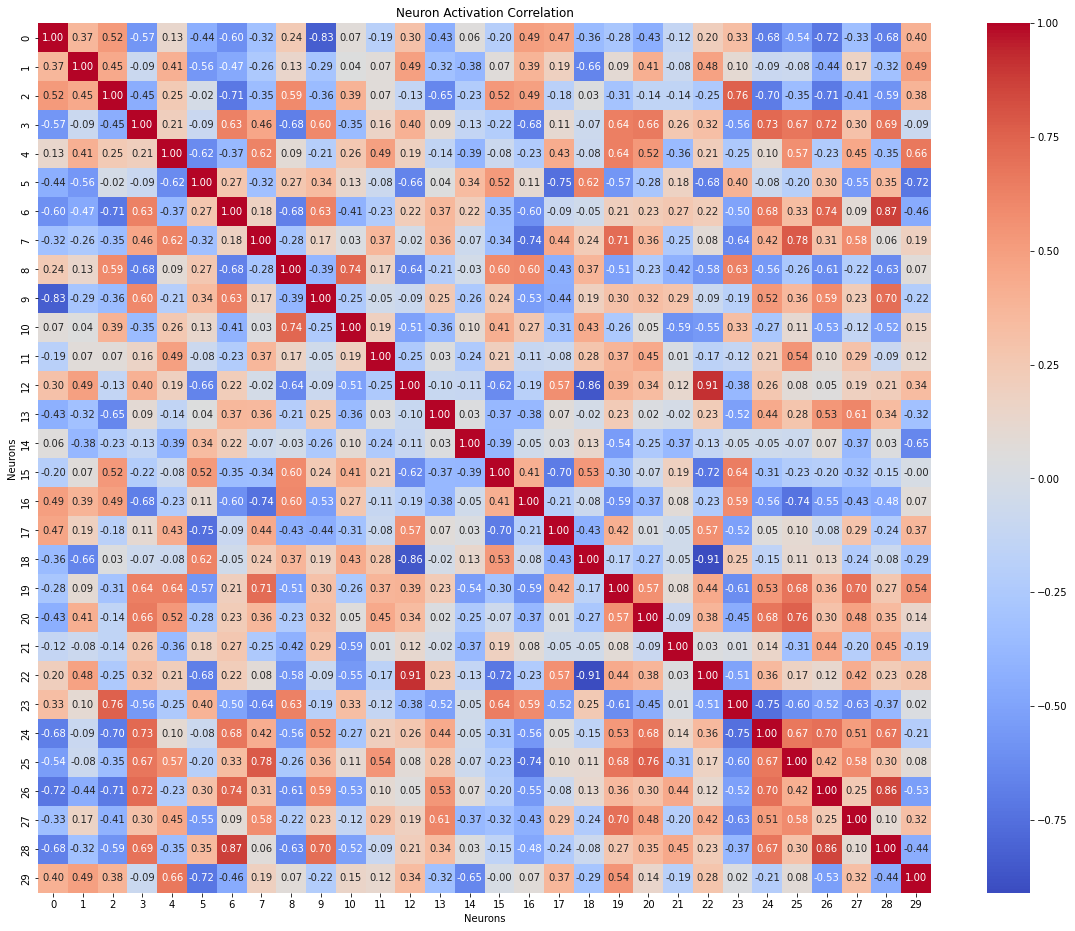

In [16]:
# Calculate neuron-wise correlation across epochs

# you could also reshape to (epochs x neurons) by averaging across samples for simplicity
# for pure correlation analysis this might be not so good as behaviour might be
# averaged out

#epoch_mean_activations = np.mean(all_epoch_activations, axis=1)  # Shape: epochs x neurons

# Calculate correlations between neurons
correlation_matrix = np.corrcoef(flattened_activations)  # Transpose to get neurons x epochs in case of averaging

# Visualize the correlation matrix
fig = plt.figure(figsize=(20, 16));
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f');
plt.title('Neuron Activation Correlation');
plt.xlabel('Neurons');
plt.ylabel('Neurons');

### Exercise 2)

- Experiment with the new Callback.
- How many Neurons provide suitable complexity for our problem?

One can suppose that the Neurons are differently activated for each sample within a training epoch

- Visualize the behavior of the Neurons during the last epoch. What do you see?

#### Hint for the last part :-)

In [17]:
last_epoch_activations = all_epoch_activations[-1]  # Shape: (num_samples, num_neurons)
transposed_activations = np.transpose(last_epoch_activations)  # Shape: (num_neurons, num_samples)
np.shape(transposed_activations)

(30, 14448)

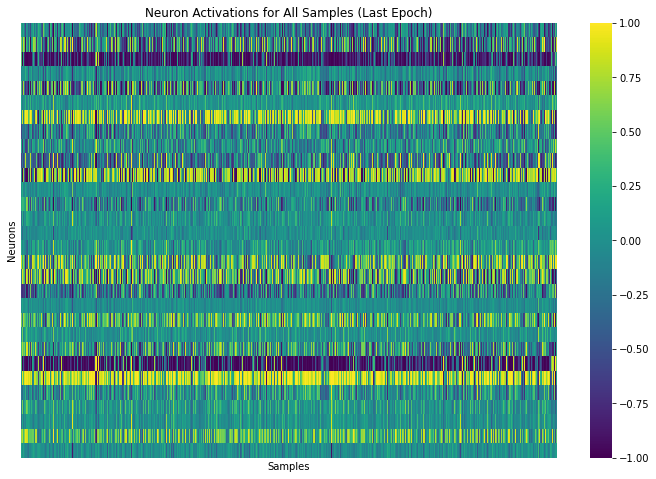

In [18]:
plt.figure(figsize=(12, 8))
sns.heatmap(transposed_activations, cmap='viridis', annot=False, xticklabels=False, yticklabels=False)
plt.title("Neuron Activations for All Samples (Last Epoch)")
plt.xlabel("Samples")
plt.ylabel("Neurons")
plt.show()

### 5.3) Sensitivity Analysis

We've discussed during theory lectures that it is a good idea to understand what the model interprets as "important"!  

### Short summary why Sensitivity Analysis makes sense:


- Understand Feature Importance:  

Sensitivity analysis allows us to understand which input features most influence the model’s predictions. Large gradients for specific features indicate that these features have a significant impact on the output.

- Improving Model Interpretability:  

Models like neural networks are often considered black boxes because it's hard to interpret how they arrive at predictions. Sensitivity analysis provides insights into the model's inner workings, making it easier to trust and refine the model.  

- Detecting Overfitting and Redundancy:  

By analyzing how the model reacts to different features, we can identify if certain features are too influential (possibly leading to overfitting) or if features are redundant. This helps in improving the model’s generalization ability by removing or transforming such features.

- Model Debugging:  

If the model is not behaving as expected, sensitivity analysis can help identify if the model is overly sensitive to irrelevant or noise features, which can help pinpoint issues.

Of course the model that is analyzed needs a certain degree of predictive power (performance). I've setup a suitable configuration for our first 3-layer FFNN.

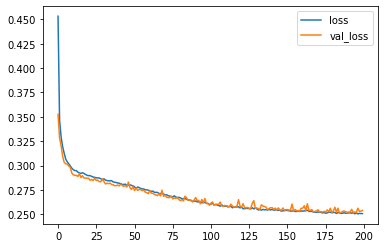

In [19]:
tf.random.set_seed(42)

EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)

NNRegModel1=Sequential()

NNRegModel1.add(InputLayer(input_shape=(7,))) # Input shape = 7 features
NNRegModel1.add(Dense(10,activation='tanh',use_bias=True))
NNRegModel1.add(Dense(1,use_bias=True))

#sgd
sgd = SGD(learning_rate=0.15)
#Adam
myAdam=keras.optimizers.Adam(learning_rate=0.03, beta_1=0.9, beta_2=0.999, amsgrad=True)

NNRegModel1.compile(loss='mean_squared_error', optimizer=sgd)

NNRegModel1.fit(X_housing_train, y_housing_train_sc,
          shuffle=True,
          epochs=500,
          batch_size=500,
          verbose=0,
          validation_data=(X_housing_test, y_housing_test_sc),                  
          callbacks=[plot_losses, EarlyStopping]);

In [20]:
#make predictions
y_pred_train_sc = NNRegModel1.predict(X_housing_train)
y_pred_test_sc = NNRegModel1.predict(X_housing_test)

# Inverse transform to get the predicted values back to the original scale
y_pred_train_original = Yscaler.inverse_transform(y_pred_train_sc)
y_pred_test_original = Yscaler.inverse_transform(y_pred_test_sc)

#calculate performance measures
r2_train=r2_score(y_pred_train_original,np.array(y_housing_train))
r2_test=r2_score(y_pred_test_original,np.array(y_housing_test))

rmse_train=np.sqrt(mean_squared_error(y_pred_train_original,np.array(y_housing_train)))
rmse_test=np.sqrt(mean_squared_error(y_pred_test_original,np.array(y_housing_test)))

rmse_perc_train=rmse_train/np.mean(np.array(y_housing_train))
rmse_perc_test=rmse_test/np.mean(np.array(y_housing_test))

print(r2_train, r2_test)
print(rmse_train, rmse_test)
print(rmse_perc_train, rmse_perc_test)

194/194 [==============================] - 0s 676us/step
0.6639630909583698 0.6573222368176739
57778.02127089794 58034.2334806164
0.27922344527528264 0.2807698497132497


The performance seems to be ok! :-) => next step...

Let's define a function to calculate the sensitivities from the gradient.

Our function will calculate the sensitivity of the model's predictions with respect to the input features. Let's break it down step by step and understand how it works:

### 1. Converting Input Data to TensorFlow Tensor:

    X_train_tensor = tf.convert_to_tensor(X_housing_train, dtype=tf.float32)

Explanation: The input data X_housing_train is converted to a TensorFlow tensor (tf.float32) so that TensorFlow operations (such as gradient computation) can be applied to it. Tensors are the fundamental data structure in TensorFlow, and they allow automatic differentiation to be performed efficiently.

Why it's useful: TensorFlow uses tensors as inputs and outputs for its models. Converting the data to tensors ensures compatibility with TensorFlow operations, enabling you to use automatic differentiation and compute gradients easily.

### 2. Function to Compute Sensitivity:

    def compute_dataset_sensitivity(model, X_dataset):
        all_gradients = []
        for sample in X_dataset:  # Iterate over each sample
            with tf.GradientTape() as tape:
                sample = tf.expand_dims(sample, axis=0)  # Add batch dimension
                tape.watch(sample)
                prediction = model(sample)
            gradients = tape.gradient(prediction, sample)
            all_gradients.append(gradients.numpy().flatten())  # Flatten to 1D
    return np.array(all_gradients)

Breakdown:

tf.GradientTape():  

This is the core tool in TensorFlow for automatic differentiation. It records all operations performed on the sample (i.e., the input data) so that we can compute gradients with respect to it.
Inside the tape, we perform the forward pass through the model (model(sample)), which computes the prediction for the given input.  


tape.watch(sample):

This tells TensorFlow to watch the tensor sample for any operations so that gradients can be computed with respect to it. Without this, TensorFlow wouldn’t track the input data to compute gradients.  

tape.gradient(prediction, sample):

This computes the gradient of the model’s output (the prediction) with respect to the input data (sample). This tells you how much the output would change if the input features are slightly adjusted. The gradient shows the sensitivity of the model’s prediction to each input feature.

Flattening the Gradient:  

gradients.numpy().flatten() converts the computed gradients (which are tensors) to NumPy arrays and flattens them to 1D. This simplifies the process of storing and analyzing them.

Storing Gradients: 

The gradients for each sample are stored in all_gradients, which will later be converted into a NumPy array for further analysis.


In [21]:
# Convert the training data to a TensorFlow tensor
X_train_tensor = tf.convert_to_tensor(X_housing_train, dtype=tf.float32)

In [22]:
# Function to compute gradients for the entire dataset
def compute_dataset_sensitivity(model, X_dataset):
    all_gradients = []
    for sample in X_dataset:  # Iterate over each sample
        with tf.GradientTape() as tape:
            sample = tf.expand_dims(sample, axis=0)  # Add batch dimension
            tape.watch(sample)
            prediction = model(sample)
        gradients = tape.gradient(prediction, sample)
        all_gradients.append(gradients.numpy().flatten())  # Flatten to 1D
    return np.array(all_gradients)

In [23]:
# Calculate sensitivities
all_sensitivities = compute_dataset_sensitivity(NNRegModel1, X_train_tensor)

# Aggregate sensitivities (mean absolute value for each feature)
mean_absolute_sensitivity = np.mean(np.abs(all_sensitivities), axis=0)

# Aggregate sensitivities (mean value for each feature)
mean_sensitivity = np.mean(all_sensitivities, axis=0)

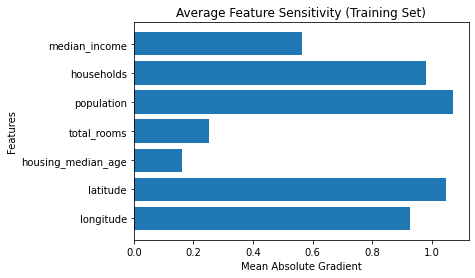

In [24]:
# Extract feature names from the DataFrame for plotting
feature_names = X_housing.columns.tolist()

# Plot the average feature sensitivity
plt.barh(feature_names, mean_absolute_sensitivity)
plt.title("Average Feature Sensitivity (Training Set)")
plt.xlabel("Mean Absolute Gradient")
plt.ylabel("Features")
plt.show()

In [25]:
mean_absolute_sensitivity

array([0.9287442 , 1.0492172 , 0.16021213, 0.25353938, 1.07104   ,
       0.97984797, 0.5640659 ], dtype=float32)

Of course the sensitivities may change slightly during training.

We could think about this like:  

The model just has to find out what is interesting and needs time to adjust.

### Exercise 3)

- Analyze how Sensitivities change during training. First choose a model that has only trained few epochs and then one where the loss has already converged.
- Plot the sensitivities and compare the changes.
- Discuss the results. What makes sense?

Up to now we have plotted the mean absolute sensitivities. But it is also interesting to know if there are negative values.

- Plot the mean sensitivities. What do you see? 
- What does that mean for Feature-Target relations?

Let's watch the changes during training. We can just do the analysis in a loop over the epochs:

In [26]:


# Function to compute dataset sensitivity
def compute_dataset_sensitivity(model, X_data):
    X_tensor = tf.convert_to_tensor(X_data, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(X_tensor)
        predictions = model(X_tensor)
    sensitivities = tape.gradient(predictions, X_tensor)
    return sensitivities.numpy()  # Values of sensitivities

# Early Stopping
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)

# Initialize model
NNRegModel1=Sequential()

NNRegModel1.add(InputLayer(input_shape=(7,))) # Input shape = 7 features
NNRegModel1.add(Dense(15,activation='tanh',use_bias=True))
NNRegModel1.add(Dense(1,use_bias=True))

sgd = SGD(learning_rate=0.3)
NNRegModel1.compile(loss='mean_squared_error', optimizer=sgd)

# Initialize variables for training
n_epochs = 100
batch_size = 100
feature_names = X_housing.columns.tolist()
ma_sensitivity_over_epochs = []  # To store mean absolute sensitivities across epochs
mean_sensitivity_over_epochs = []  # To store meansensitivities across epochs

# Training loop
for epoch in range(1, n_epochs + 1):
    # Train model for one epoch
    NNRegModel1.fit(
        X_housing_train, y_housing_train_sc,
        shuffle=True,
        epochs=1,
        batch_size=batch_size,
        verbose=0,
        validation_data=(X_housing_test, y_housing_test_sc),
        callbacks=[EarlyStopping]
    )
    
    # Compute sensitivities after current epoch
    all_sensitivities = compute_dataset_sensitivity(NNRegModel1, X_housing_train)
    
    mean_absolute_sensitivity = np.mean(np.abs(all_sensitivities), axis=0)
    ma_sensitivity_over_epochs.append(mean_absolute_sensitivity)
    
    mean_sensitivity = np.mean(all_sensitivities, axis=0)
    mean_sensitivity_over_epochs.append(mean_sensitivity)

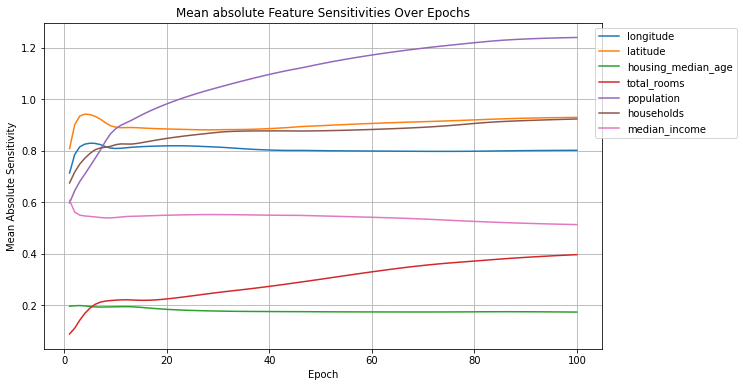

In [27]:
# Convert sensitivities to numpy array for plotting
ma_sensitivity_over_epochs = np.array(ma_sensitivity_over_epochs)

# Plot sensitivities over epochs
plt.figure(figsize=(10, 6))
for i, feature_name in enumerate(feature_names):
    plt.plot(range(1, n_epochs + 1), ma_sensitivity_over_epochs[:, i], label=feature_name)

plt.title("Mean absolute Feature Sensitivities Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Sensitivity")
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.grid(True)

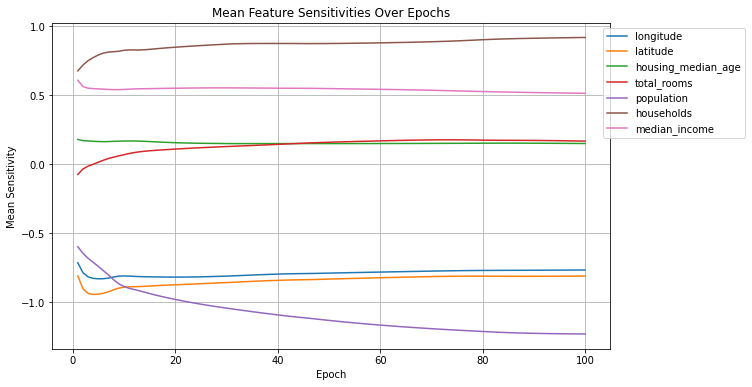

In [28]:
# Convert sensitivities to numpy array for plotting
mean_sensitivity_over_epochs = np.array(mean_sensitivity_over_epochs)

# Plot sensitivities over epochs
plt.figure(figsize=(10, 6))
for i, feature_name in enumerate(feature_names):
    plt.plot(range(1, n_epochs + 1), mean_sensitivity_over_epochs[:, i], label=feature_name)

plt.title("Mean Feature Sensitivities Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Mean Sensitivity")
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.grid(True)

After the model has been trained the model's weights and parameters are now fixed. Once the training is complete, you can evaluate the gradients of the trained model for any input data. The trained model already has optimized weights, and you're simply computing the gradients with respect to those fixed weights.

This is useful to analyze e.g. monotonic behaviour of the features.

In [29]:
# Convert the training data to a TensorFlow tensor
X_train_tensor = tf.convert_to_tensor(X_housing_train, dtype=tf.float32)

# Function to compute gradients for all samples after training
def compute_sensitivity_after_training(model, X_dataset):
    all_gradients = []
    for sample in X_dataset:  # Iterate over each sample
        with tf.GradientTape() as tape:
            sample = tf.expand_dims(sample, axis=0)  # Add batch dimension
            tape.watch(sample)
            prediction = model(sample)
        gradients = tape.gradient(prediction, sample)
        all_gradients.append(gradients.numpy().flatten())  # Flatten to 1D
    return np.array(all_gradients)


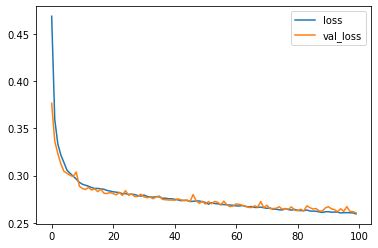

In [30]:
tf.random.set_seed(42)

EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15,restore_best_weights=True)

NNRegModel2=Sequential()

NNRegModel2.add(InputLayer(input_shape=(7,))) # Input shape = 7 features
NNRegModel2.add(Dense(10,activation='tanh',use_bias=True))
NNRegModel2.add(Dense(1,use_bias=True))

#sgd
sgd = SGD(learning_rate=0.15)
#Adam
myAdam=keras.optimizers.Adam(learning_rate=0.03, beta_1=0.9, beta_2=0.999, amsgrad=True)

NNRegModel2.compile(loss='mean_squared_error', optimizer=sgd)

NNRegModel2.fit(X_housing_train, y_housing_train_sc,
          shuffle=True,
          epochs=100,
          batch_size=500,
          verbose=0,
          validation_data=(X_housing_test, y_housing_test_sc),                  
          callbacks=[plot_losses, EarlyStopping]);

In [31]:
# Compute sensitivities for all samples (post-training)
all_sensitivities_last_epoch = compute_sensitivity_after_training(NNRegModel2, X_train_tensor)


In [32]:
np.shape(all_sensitivities_last_epoch.T)

(7, 14448)

Visualization of Sensitivity:   

After computing the gradients for all samples, you can visualize them in a matrix where the features (input variables) are on the y-axis and the samples are on the x-axis. This allows you to see which features are most sensitive to changes in each training sample's output.

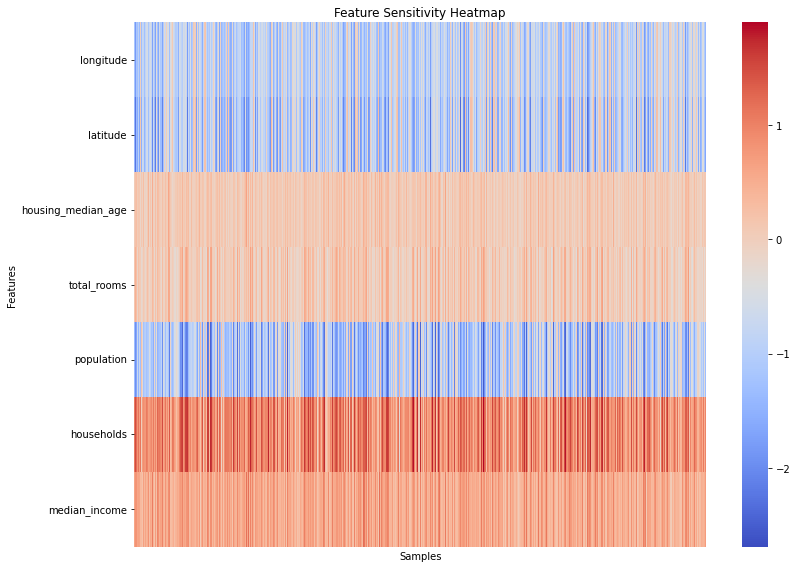

In [33]:
# Transpose the sensitivity matrix to flip axes (samples x features -> features x samples)
flipped_sensitivities_matrix = all_sensitivities_last_epoch.T

# Plot the heatmap with flipped axes
plt.figure(figsize=(12, 8))
sns.heatmap(
    flipped_sensitivities_matrix, 
    cmap='coolwarm', 
    yticklabels=feature_names,  # Use feature names on the y-axis
    xticklabels=False,          # Suppress x-axis labels (optional for clarity)
    cbar=True
)

plt.title("Feature Sensitivity Heatmap")
plt.xlabel("Samples")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


### Exercise 4)

- Use the sensitivity Analysis for Input Pruning!
- How does pruning influence the model performance?